In [ ]:
import sys
import os
import cv2
import torch
import numpy as np
from PIL import Image

sys.path.append('/home/marcotuliopin/home/studies/poc/hha/')
from hha.utils.getCameraParam import getCameraParam
from hha.getHHA import getHHA as getHHA

class HHATransform:
    """
    Converte imagens de profundidade para o formato HHA usando a implementação Depth2HHA-python.
    Esta versão usa a implementação completa de Gupta et al.
    """
    def __init__(self, normalize=True):
        self.normalize = normalize
        self.camera_matrix = getCameraParam('color')
        
        # Valores para normalização (ajustar conforme necessário)
        self.mean = torch.tensor([0.5, 0.5, 0.5])
        self.std = torch.tensor([0.2, 0.2, 0.2])
        
    def __call__(self, depth_img):
        """
        Converte uma imagem de profundidade PIL para HHA.
        
        Args:
            depth_img: PIL Image com profundidade em uint16 (milímetros)
            
        Returns:
            Tensor de formato HHA (3, H, W)
        """
        # Usar a implementação Depth2HHA-python
        # O getHHA espera a profundidade em metros
        print(f"Depth image shape: {depth_img.shape}, dtype: {depth_img.dtype}")
        print(f"Camera matrix: \n{self.camera_matrix}")
        hha = getHHA(self.camera_matrix, depth_img, depth_img)
        
        # Converter de BGR (saída do OpenCV) para RGB
        hha_rgb = cv2.cvtColor(hha, cv2.COLOR_BGR2RGB)
        
        # Converter para tensor e reorganizar dimensões de (H,W,3) para (3,H,W)
        hha_tensor = torch.from_numpy(hha_rgb).float().permute(2, 0, 1) / 255.0
        
        # Normalizar se solicitado
        if self.normalize:
            for c in range(3):
                hha_tensor[c] = (hha_tensor[c] - self.mean[c]) / self.std[c]
                
        return hha_tensor

data_root = "data/nyuv2"
depth_dir = os.path.join(data_root, "train_depth" if os.path.exists(os.path.join(data_root, "train_depth")) else "test_depth")
depth_file = sorted(os.listdir(depth_dir))[20]  # Primeira imagem
depth_path = os.path.join(depth_dir, depth_file)

# Carregar a imagem como PIL
depth_img = cv2.imread(depth_path, cv2.COLOR_BGR2GRAY) / 1e4
camera_matrix = getCameraParam('color')
hha = getHHA(camera_matrix, depth_img, depth_img)

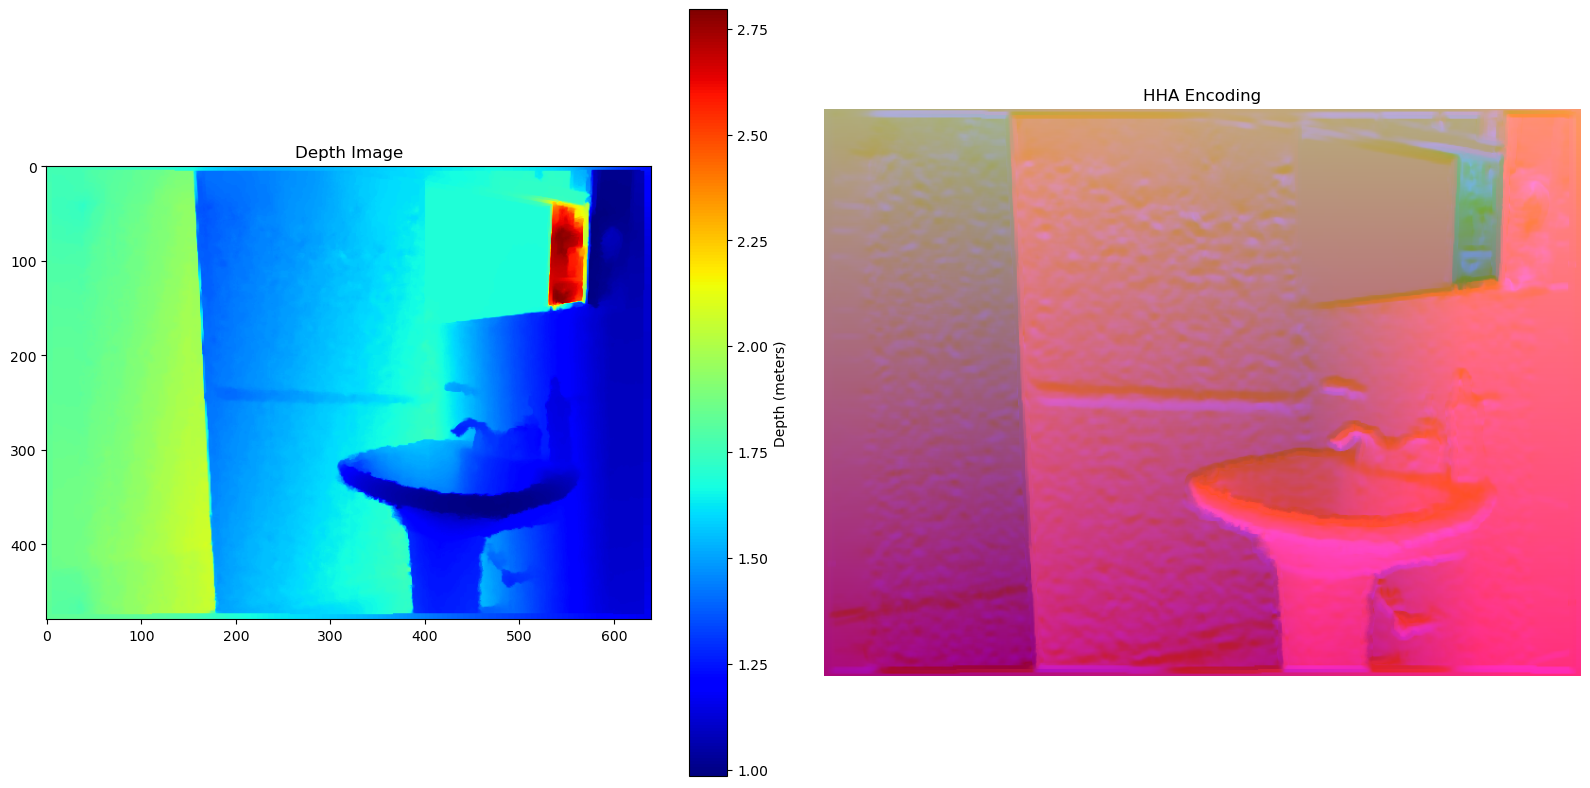

In [10]:
from matplotlib import pyplot as plt


plt.figure(figsize=(16, 8))

# Display depth image
plt.subplot(1, 2, 1)
plt.title("Depth Image")
plt.imshow(depth_img, cmap='jet')  # Using jet colormap for better depth visualization
plt.colorbar(label='Depth (meters)')

# Display HHA image
plt.subplot(1, 2, 2)
plt.title("HHA Encoding")
plt.imshow(cv2.cvtColor(hha, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
plt.axis('off')

plt.tight_layout()
plt.show()

Found 795 HHA images in data/nyuv2/train_hha


Processing HHA images: 100%|██████████| 795/795 [00:09<00:00, 87.34it/s]



===== HHA Image Statistics =====
Number of images: 795
Image dimensions: (480, 640, 3)

--- H_channel (Horizontal disparity) ---
mean: 111.9558
std: 37.7235
min: 38.0000
max: 218.0000
25%: 89.0000
median: 120.0000
75%: 133.0000

--- H_channel (Height) ---
mean: 113.2798
std: 67.0073
min: 0.0000
max: 255.0000
25%: 62.0000
median: 103.0000
75%: 160.0000

--- A_channel (Angle) ---
mean: 137.2973
std: 58.2505
min: 47.0000
max: 255.0000
25%: 91.0000
median: 126.0000
75%: 173.0000

===== For PyTorch Normalization =====
mean=[0.4390, 0.4442, 0.5384]
std=[0.1479, 0.2628, 0.2284]

Generating histograms...


100%|██████████| 100/100 [00:00<00:00, 112.82it/s]


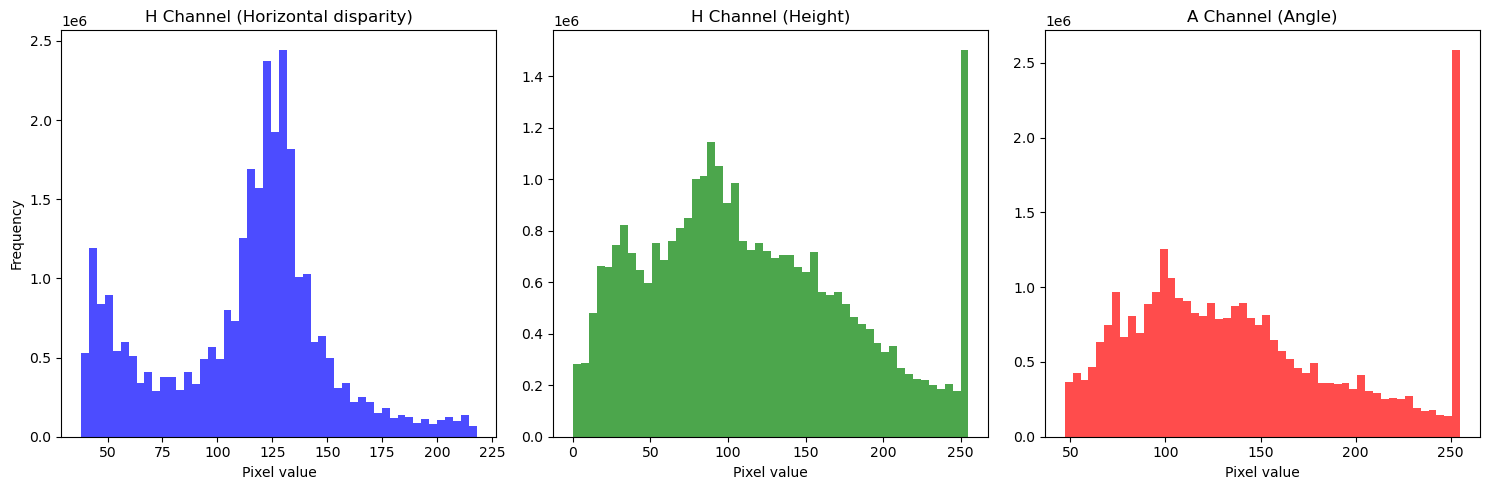

Histogram saved as 'hha_histograms.png'


In [11]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from pathlib import Path

def calculate_hha_statistics(hha_dir):
    """
    Calculate statistics for each channel of HHA images in a directory.
    
    Args:
        hha_dir: Path to directory containing HHA images
    
    Returns:
        dict: Statistics for each channel (mean, std, min, max)
    """
    # Make sure the directory exists
    hha_path = Path(hha_dir)
    if not hha_path.exists():
        raise FileNotFoundError(f"Directory not found: {hha_dir}")
    
    # Get all HHA image files
    hha_files = list(hha_path.glob('*_hha.png'))
    if not hha_files:
        raise ValueError(f"No HHA images found in {hha_dir}")
    
    print(f"Found {len(hha_files)} HHA images in {hha_dir}")
    
    # Initialize arrays to store statistics
    # We'll accumulate channel sums and squared sums for computing mean and std
    h_vals = []
    h_vals2 = []
    a_vals = []
    a_vals2 = []
    
    # Process each image
    for file_path in tqdm(hha_files, desc="Processing HHA images"):
        # Read the HHA image (OpenCV reads as BGR)
        hha = cv2.imread(str(file_path))
        
        if hha is None:
            print(f"Warning: Could not read {file_path}")
            continue
            
        # Convert from BGR to HHA order (assuming B=H, G=H, R=A)
        # H = Horizontal disparity (B)
        # H = Height from ground (G)
        # A = Angle with gravity (R)
        h_channel = hha[:,:,0].astype(np.float32)  # H channel (B in BGR)
        h2_channel = hha[:,:,1].astype(np.float32)  # H channel (G in BGR)
        a_channel = hha[:,:,2].astype(np.float32)  # A channel (R in BGR)
        
        # Accumulate values for statistics
        h_vals.append(h_channel.flatten())
        h_vals2.append(h2_channel.flatten())
        a_vals.append(a_channel.flatten())
    
    # Concatenate all values
    h_all = np.concatenate(h_vals)
    h2_all = np.concatenate(h_vals2)
    a_all = np.concatenate(a_vals)
    
    # Calculate statistics
    stats = {
        'H_channel (Horizontal disparity)': {
            'mean': float(np.mean(h_all)),
            'std': float(np.std(h_all)),
            'min': float(np.min(h_all)),
            'max': float(np.max(h_all)),
            '25%': float(np.percentile(h_all, 25)),
            'median': float(np.median(h_all)),
            '75%': float(np.percentile(h_all, 75)),
        },
        'H_channel (Height)': {
            'mean': float(np.mean(h2_all)),
            'std': float(np.std(h2_all)),
            'min': float(np.min(h2_all)),
            'max': float(np.max(h2_all)),
            '25%': float(np.percentile(h2_all, 25)),
            'median': float(np.median(h2_all)),
            '75%': float(np.percentile(h2_all, 75)),
        },
        'A_channel (Angle)': {
            'mean': float(np.mean(a_all)),
            'std': float(np.std(a_all)),
            'min': float(np.min(a_all)),
            'max': float(np.max(a_all)),
            '25%': float(np.percentile(a_all, 25)),
            'median': float(np.median(a_all)),
            '75%': float(np.percentile(a_all, 75)),
        },
        'Overall': {
            'num_images': len(hha_files),
            'image_dimensions': hha.shape if len(hha_files) > 0 else None
        }
    }
    
    return stats

def print_statistics(stats):
    """Print statistics in a readable format"""
    print("\n===== HHA Image Statistics =====")
    print(f"Number of images: {stats['Overall']['num_images']}")
    if stats['Overall']['image_dimensions']:
        print(f"Image dimensions: {stats['Overall']['image_dimensions']}")
    
    for channel, channel_stats in stats.items():
        if channel != 'Overall':
            print(f"\n--- {channel} ---")
            for stat_name, stat_value in channel_stats.items():
                print(f"{stat_name}: {stat_value:.4f}")
    
    # Print normalization values in PyTorch format
    print("\n===== For PyTorch Normalization =====")
    means = [
        stats['H_channel (Horizontal disparity)']['mean'] / 255.0,
        stats['H_channel (Height)']['mean'] / 255.0, 
        stats['A_channel (Angle)']['mean'] / 255.0
    ]
    stds = [
        stats['H_channel (Horizontal disparity)']['std'] / 255.0,
        stats['H_channel (Height)']['std'] / 255.0,
        stats['A_channel (Angle)']['std'] / 255.0
    ]
    print(f"mean=[{means[0]:.4f}, {means[1]:.4f}, {means[2]:.4f}]")
    print(f"std=[{stds[0]:.4f}, {stds[1]:.4f}, {stds[2]:.4f}]")

if __name__ == "__main__":
    # Calculate statistics for HHA images
    hha_dir = "data/nyuv2/train_hha"
    stats = calculate_hha_statistics(hha_dir)
    print_statistics(stats)
    
    # Create histograms for each channel
    print("\nGenerating histograms...")
    import matplotlib.pyplot as plt
    
    # Re-read a subset of images for histogram visualization
    hha_files = list(Path(hha_dir).glob('*_hha.png'))
    sample_size = min(100, len(hha_files))  # Use up to 100 images for histogram
    
    h_samples = []
    h2_samples = []
    a_samples = []
    
    for file_path in tqdm(np.random.choice(hha_files, sample_size, replace=False)):
        hha = cv2.imread(str(file_path))
        if hha is not None:
            h_samples.append(hha[:,:,0].flatten())
            h2_samples.append(hha[:,:,1].flatten())
            a_samples.append(hha[:,:,2].flatten())
    
    # Combine samples
    h_all = np.concatenate(h_samples)
    h2_all = np.concatenate(h2_samples)
    a_all = np.concatenate(a_samples)
    
    # Create histograms
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(h_all, bins=50, color='blue', alpha=0.7)
    plt.title('H Channel (Horizontal disparity)')
    plt.xlabel('Pixel value')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.hist(h2_all, bins=50, color='green', alpha=0.7)
    plt.title('H Channel (Height)')
    plt.xlabel('Pixel value')
    
    plt.subplot(1, 3, 3)
    plt.hist(a_all, bins=50, color='red', alpha=0.7)
    plt.title('A Channel (Angle)')
    plt.xlabel('Pixel value')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Histogram saved as 'hha_histograms.png'")